In [1]:
# Retail Demand Forecasting using Rossmann Sales Data #

**Author:** Tarun  
**Course:** MSc Data Science, University of Hertfordshire  
**Objective:** Forecast daily store sales using machine learning models (Linear Regression, Random Forest, XGBoost)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA = '/content/drive/My Drive/Rossman store sales'

Mounted at /content/drive


# **Importing Libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams.update({"figure.figsize":(10,5), "axes.titlesize":14, "axes.labelsize":12})

TRAIN_PATH = os.path.join(DATA, "train.csv")
STORE_PATH = os.path.join(DATA, "store.csv")

# **Loading and Sorting Data**

In [4]:
train = pd.read_csv(TRAIN_PATH, parse_dates=['Date'])
store = pd.read_csv(STORE_PATH)

print("Train Shape:", train.shape)
print("Store Shape:", store.shape)

df = train.merge(store, on='Store', how='left')
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
display(df.head())

Train Shape: (1017209, 9)
Store Shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,2013-01-01,0,0,0,0,a,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [5]:
df.info()
display(df.describe().T)
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
print("Missing > 0% (top12):"); display(missing_pct[missing_pct>0].head(12))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

,count,mean,min,25%,50%,75%,max,std
Store,1017209.0,558.429727,1.0,280.0,558.0,838.0,1115.0,321.908651
DayOfWeek,1017209.0,3.998341,1.0,2.0,4.0,6.0,7.0,1.997391
Date,1017209,2014-04-11 01:30:42.846062336,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
Sales,1017209.0,5773.818972,0.0,3727.0,5744.0,7856.0,41551.0,3849.926175
Customers,1017209.0,633.145946,0.0,405.0,609.0,837.0,7388.0,464.411734
Open,1017209.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539
Promo,1017209.0,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759
SchoolHoliday,1017209.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056
CompetitionDistance,1014567.0,5430.085652,20.0,710.0,2330.0,6890.0,75860.0,7715.3237
CompetitionOpenSinceMonth,693861.0,7.222866,1.0,4.0,8.0,10.0,12.0,3.211832


Missing > 0% (top12):


,0
Promo2SinceWeek,49.943620
PromoInterval,49.943620
Promo2SinceYear,49.943620
CompetitionOpenSinceYear,31.787764
CompetitionOpenSinceMonth,31.787764
CompetitionDistance,0.259730


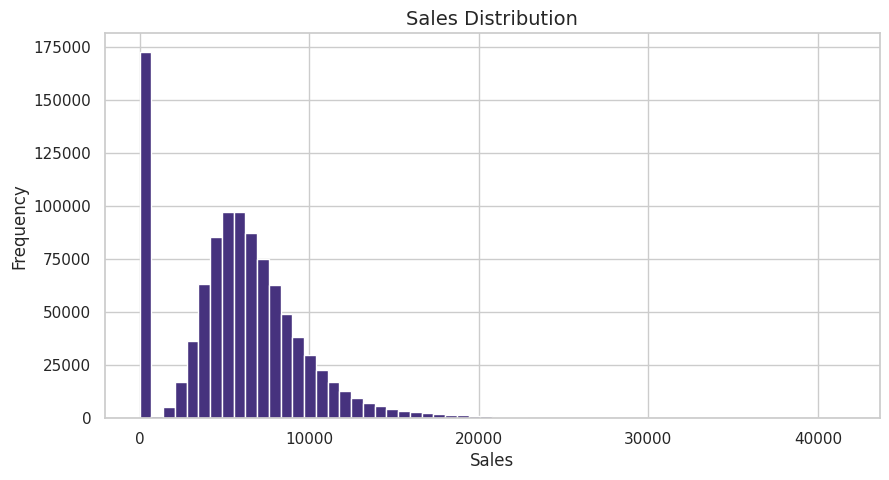

In [6]:
df["Sales"].plot(kind = "hist", bins = 60, title = "Sales Distribution"); plt.xlabel("Sales"); plt.show()

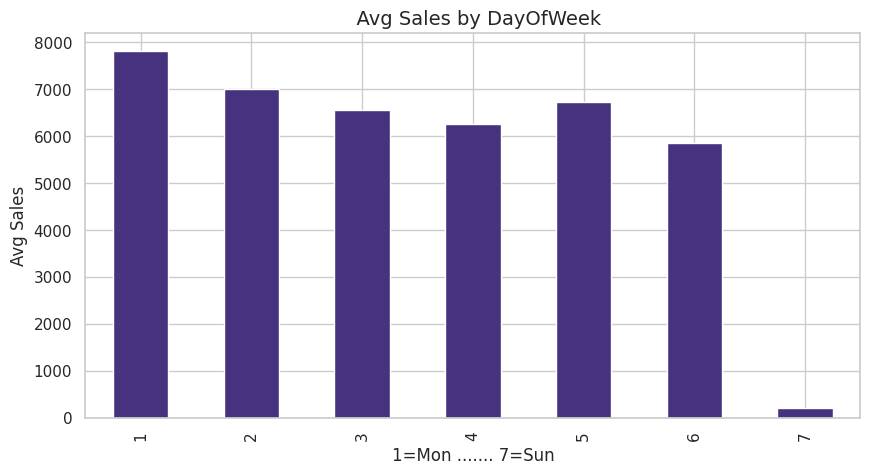

In [7]:
df.groupby("DayOfWeek")["Sales"].mean().plot(kind = "bar", title = "  Avg Sales by DayOfWeek");
plt.xlabel("1=Mon ....... 7=Sun"); plt.ylabel("Avg Sales"); plt.show()

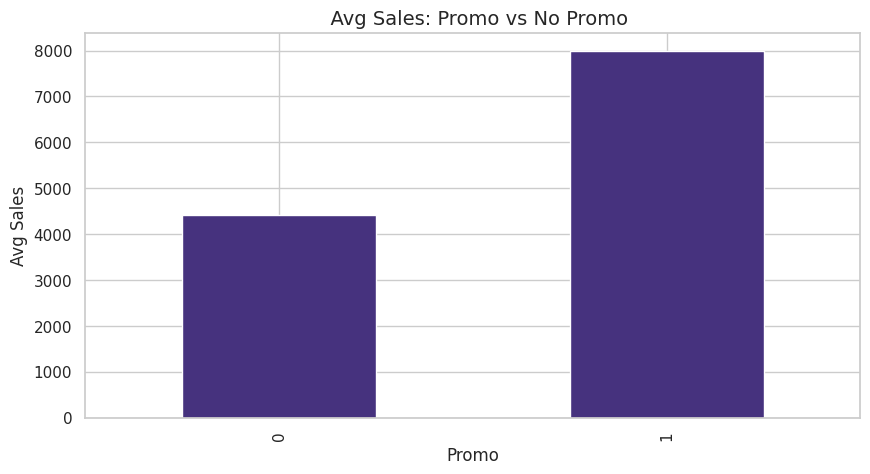

In [8]:
df.groupby("Promo")["Sales"].mean().plot(kind = "bar", title = "  Avg Sales: Promo vs No Promo");
plt.ylabel("Avg Sales"); plt.show()

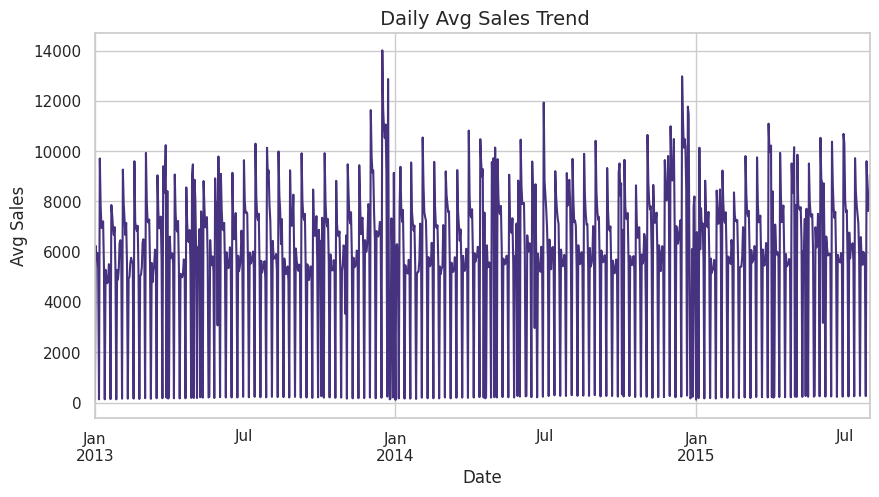

In [9]:
df.groupby("Date")["Sales"].mean().plot(title = " Daily Avg Sales Trend");
plt.ylabel("Avg Sales"); plt.show()

# **Exploratory Data Analysis**

###Highlighting columns with missing data and checking the numeric fields have right datatypes

In [10]:
overview = pd.DataFrame({"columns":df.columns, "Datatype":df.dtypes.values, "Missing Values": df.isnull().sum().values, "Unique Values": [df[c].unique() for c in df.columns]})

overview["%Missing"] = (overview["Missing Values"]/len(df)*100).round(2)

display(overview.sort_values("Missing Values", ascending=False).style.background_gradient(cmap="YlGnBu"))

##Summary Statistics Table

In [11]:
desc = df.describe(include="all").T
desc["missing%"] = df.isnull().mean().round(3)*100
desc["unique"] = [df[c].nunique() for c in df.columns]
numeric_cols = df.select_dtypes(include=["number"]).columns
display(desc.style.background_gradient(cmap = "Blues", subset = pd.IndexSlice[numeric_cols, ["std", "50%"]]))

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,missing%
Store,1017209.000000,1115,nan,nan,558.429727,1.000000,280.000000,558.000000,838.000000,1115.000000,321.908651,0.000000
DayOfWeek,1017209.000000,7,nan,nan,3.998341,1.000000,2.000000,4.000000,6.000000,7.000000,1.997391,0.000000
Date,1017209,942,nan,nan,2014-04-11 01:30:42.846062336,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,nan,0.000000
Sales,1017209.000000,21734,nan,nan,5773.818972,0.000000,3727.000000,5744.000000,7856.000000,41551.000000,3849.926175,0.000000
Customers,1017209.000000,4086,nan,nan,633.145946,0.000000,405.000000,609.000000,837.000000,7388.000000,464.411734,0.000000
Open,1017209.000000,2,nan,nan,0.830107,0.000000,1.000000,1.000000,1.000000,1.000000,0.375539,0.000000
Promo,1017209.000000,2,nan,nan,0.381515,0.000000,0.000000,0.000000,1.000000,1.000000,0.485759,0.000000
StateHoliday,1017209,5,0,855087,nan,nan,nan,nan,nan,nan,nan,0.000000
SchoolHoliday,1017209.000000,2,nan,nan,0.178647,0.000000,0.000000,0.000000,0.000000,1.000000,0.383056,0.000000
StoreType,1017209,4,a,551627,nan,nan,nan,nan,nan,nan,nan,0.000000


##Missing Values Table & Heatmap

,Column,Missing %
Promo2SinceWeek,Promo2SinceWeek,49.940000
PromoInterval,PromoInterval,49.940000
Promo2SinceYear,Promo2SinceYear,49.940000
CompetitionOpenSinceYear,CompetitionOpenSinceYear,31.790000
CompetitionOpenSinceMonth,CompetitionOpenSinceMonth,31.790000
CompetitionDistance,CompetitionDistance,0.260000


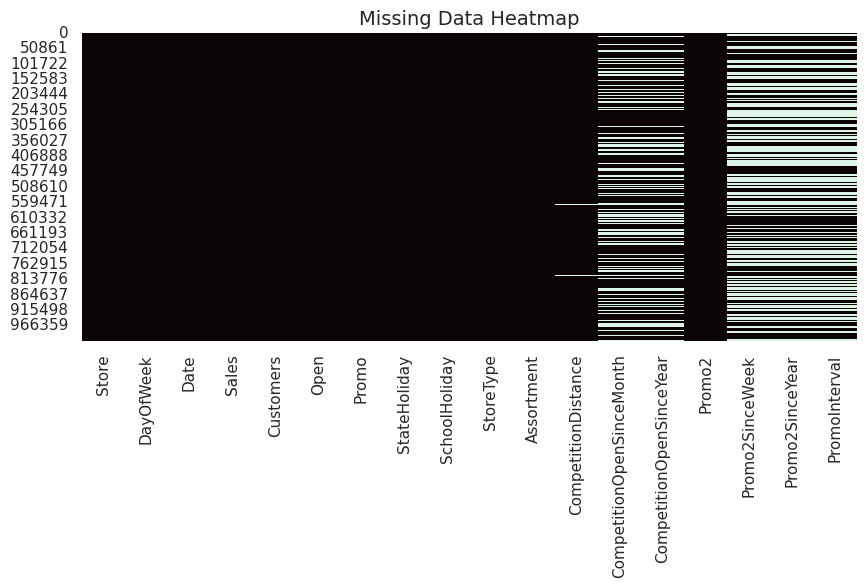

In [12]:
missing = pd.DataFrame({"Column":df.columns,
                        "Missing %": (df.isnull().mean()*100).round(2)
                      }).sort_values("Missing %", ascending=False)

display(missing[missing["Missing %"] > 0].style.background_gradient(cmap = "mako"))

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap="mako")
plt.title("Missing Data Heatmap")
plt.show()

##Categorical Variable counts Table

In [13]:
cat_cols = ["StateHoliday", "StoreType", "Assortment"]
cat_summary = pd.DataFrame({
    "Unique": [df[c].nunique() for c in cat_cols],
    "Top 5 values": [df[c].value_counts().head(5).to_dict() for c in cat_cols]})
display(cat_summary)

,Unique,Top 5 values
0,5,"{'0': 855087, 0: 131072, 'a': 20260, 'b': 6690..."
1,4,"{'a': 551627, 'd': 312912, 'c': 136840, 'b': 1..."
2,3,"{'a': 537445, 'c': 471470, 'b': 8294}"


## Sales and Cutomers in Correlation + Heatmap

,Sales,Customers,CompetitionDistance
Sales,1.000000,0.890000,-0.020000
Customers,0.890000,1.000000,-0.100000
CompetitionDistance,-0.020000,-0.100000,1.000000


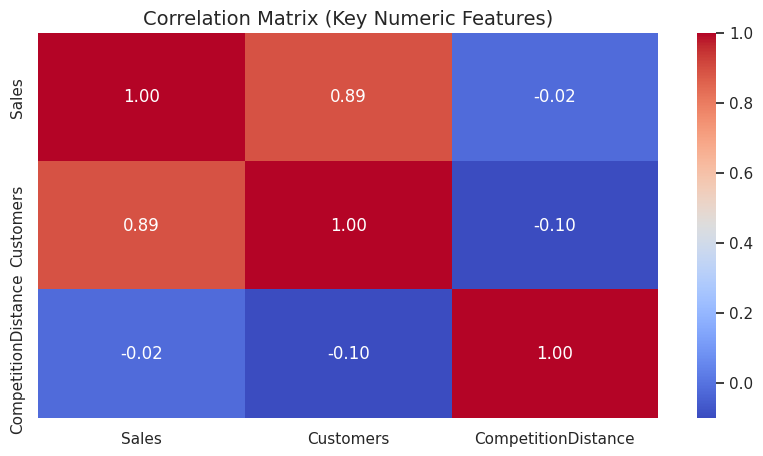

In [14]:
corr_matrix = df[["Sales", "Customers", "CompetitionDistance"]].corr().round(2)
display(corr_matrix.style.background_gradient(cmap = "coolwarm", axis = None))

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt = ".2f")
plt.title("Correlation Matrix (Key Numeric Features)")
plt.show()

##Top 10 Stores by Average Sales

,Store,Sales
0,262,20718.515924
1,817,18108.139066
2,562,17969.556263
3,1114,17200.196391
4,251,15814.087049
5,842,15242.114776
6,513,15129.942675
7,788,14949.194268
8,733,14933.288747
9,383,14320.466030


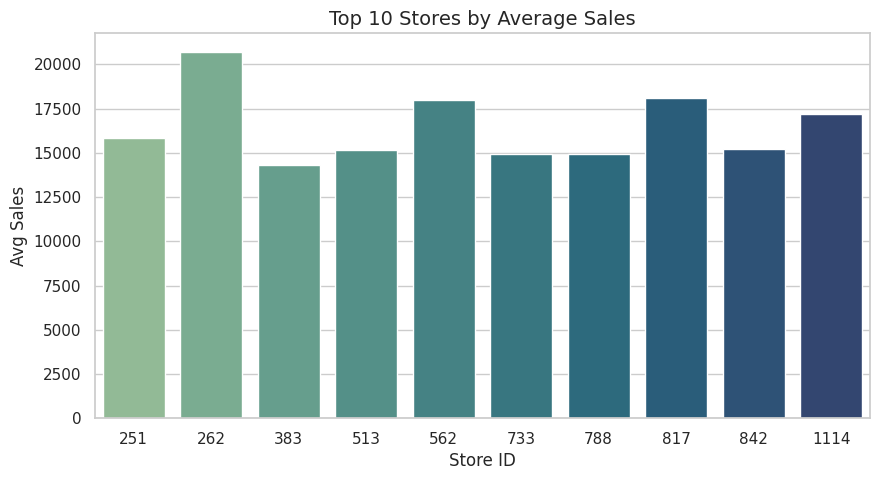

In [15]:
top10 = df.groupby("Store")["Sales"].mean().sort_values(ascending=False).head(10).reset_index()
display(top10.style.background_gradient(cmap="Greens"))

sns.barplot(data=top10, x="Store", y="Sales", palette="crest")
plt.title("Top 10 Stores by Average Sales")
plt.ylabel("Avg Sales"); plt.xlabel("Store ID")
plt.show()

## Average Sales by Day of Week

,DayOfWeek,mean,median,std
0,1,7809.040000,7310.000000,4016.530000
1,2,7005.240000,6463.000000,3142.040000
2,3,6555.880000,6133.000000,2944.380000
3,4,6247.580000,6020.000000,3209.810000
4,5,6723.270000,6434.000000,3101.010000
5,6,5847.560000,5410.000000,2873.990000
6,7,204.180000,0.000000,1613.240000


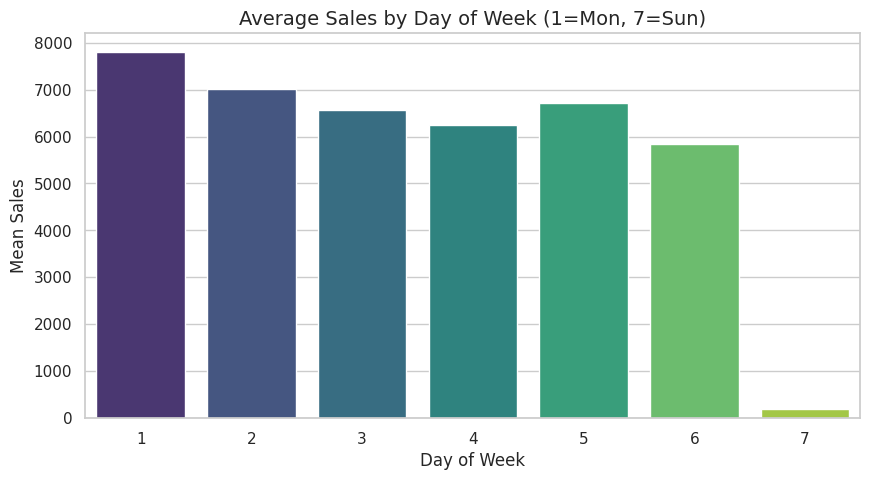

In [16]:
dow_table = df.groupby("DayOfWeek")["Sales"].agg(["mean", "median", "std"]).round(2).reset_index()
display(dow_table.style.background_gradient(cmap="viridis", subset = ["mean"]))

sns.barplot(data=dow_table, x="DayOfWeek", y="mean", palette="viridis")
plt.title("Average Sales by Day of Week (1=Mon, 7=Sun)")
plt.ylabel("Mean Sales"); plt.xlabel("Day of Week")
plt.show()

##Store Type & Assortment Analysis

StoreType Sales Summary:


,StoreType,mean,median,std
0,a,5738.180000,5618.000000,3964.030000
1,b,10058.840000,9025.500000,5280.530000
2,c,5723.630000,5766.000000,3721.700000
3,d,5641.820000,5826.000000,3473.390000


Assortment Sales Summary:


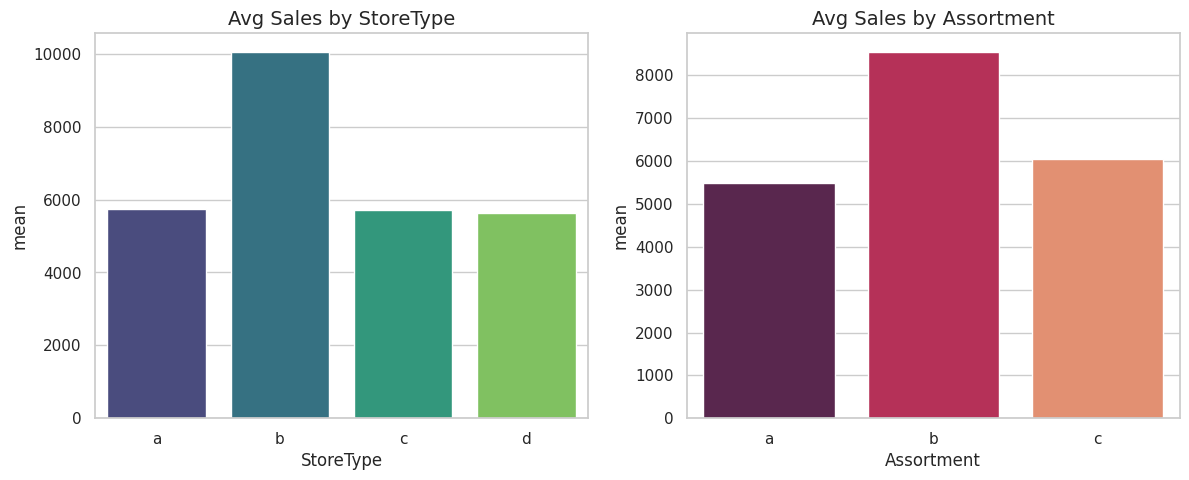

In [17]:
storetype_table = df.groupby("StoreType")["Sales"].agg(["mean", "median", "std"]).round(2).reset_index()
assort_table = df.groupby("Assortment")["Sales"].agg(["mean", "median", "std"]).round(2).reset_index()

print("StoreType Sales Summary:")
display(storetype_table.style.background_gradient(cmap="viridis", subset = ["mean"]))
print("Assortment Sales Summary:")
print(assort_table.style.background_gradient(cmap="rocket", subset = ["mean"]))

fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.barplot(data=storetype_table, x="StoreType", y="mean", ax=ax[0], palette="viridis")
ax[0].set_title("Avg Sales by StoreType")
sns.barplot(data=assort_table, x="Assortment", y="mean", ax=ax[1], palette="rocket")
ax[1].set_title("Avg Sales by Assortment")
plt.show()

## Competition Distance vs Sales

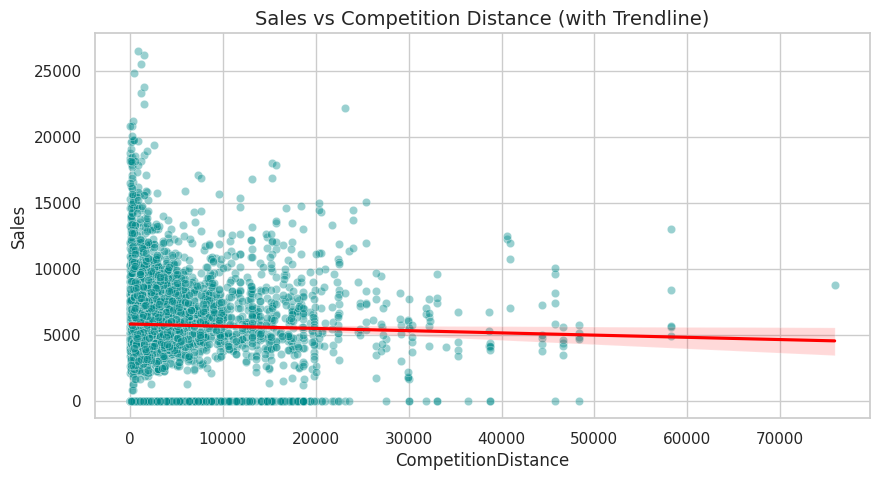

In [18]:
sample = df.sample(4000, random_state=42)
sns.scatterplot(data=sample, x="CompetitionDistance", y="Sales", alpha=0.4, color="#008B8B")
sns.regplot(data=sample, x="CompetitionDistance", y="Sales", scatter=False, color="red")
plt.title("Sales vs Competition Distance (with Trendline)")
plt.show()

##Combined Holiday Effects

,StateHoliday,SchoolHoliday,Sales
0,0,0,5388.05
1,0,1,6893.05
2,0,0,5767.92
3,0,1,7101.90
4,a,0,332.80
5,a,1,169.07
6,b,0,431.17
7,b,1,197.40
8,c,1,168.73


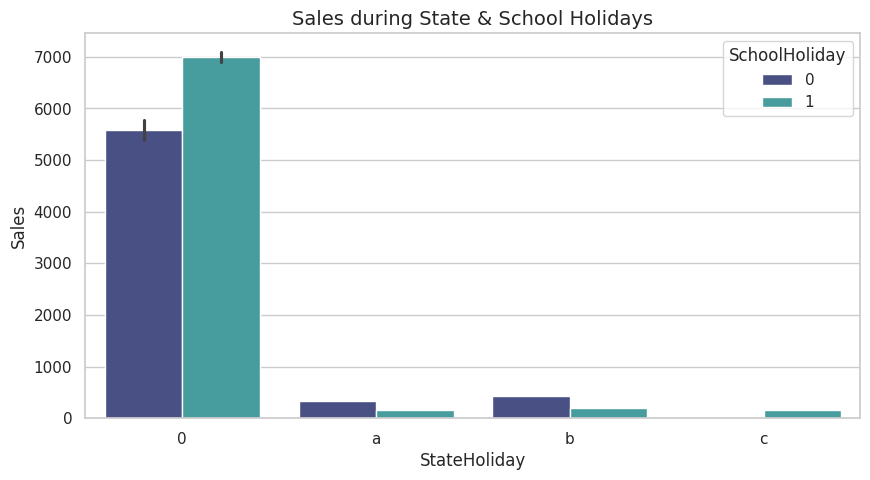

In [19]:
holiday_table = df.groupby(["StateHoliday","SchoolHoliday"])["Sales"].mean().round(2).reset_index()
display(holiday_table)

sns.barplot(data=holiday_table, x="StateHoliday", y="Sales", hue="SchoolHoliday", palette="mako")
plt.title("Sales during State & School Holidays")
plt.show()

##Trendline of Average Sales

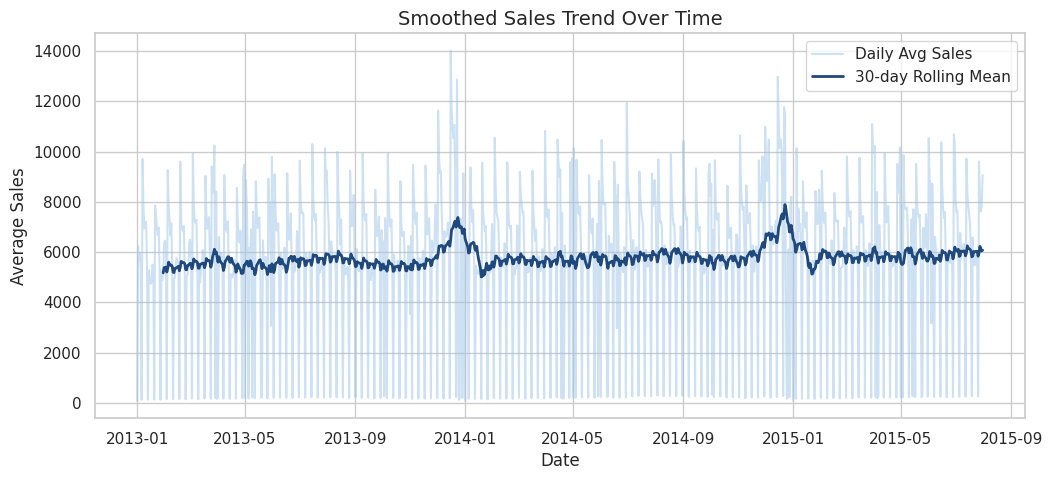

In [20]:
daily = df.groupby("Date")["Sales"].mean().reset_index()
daily["RollingMean30"] = daily["Sales"].rolling(window=30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily["Date"], daily["Sales"], alpha=0.5, label="Daily Avg Sales", color="#9fc5e8")
plt.plot(daily["Date"], daily["RollingMean30"], label="30-day Rolling Mean", color="#1f497d", linewidth=2)
plt.title("Smoothed Sales Trend Over Time")
plt.ylabel("Average Sales"); plt.xlabel("Date")
plt.legend(); plt.show()

## Summary Table for EDA Findings

In [21]:
eda_summary = pd.DataFrame({
    "Aspect": [
        "Sales Distribution", "Promotion Effect", "Day-of-Week Seasonality",
        "Monthly Trend", "Store Type Influence", "Competition Effect"],
    "Key Insights": [
        "Right-skewed distribution; few high-selling days",
        "Promo=1 → large lift in average sales",
        "Mid-week peaks, Sunday dips (closures)",
        "End-of-year seasonal rise (Nov–Dec)",
        "Type b/d stores and rich assortments perform best",
        "Weak negative correlation: farther competitor = slightly higher sales"
    ]})

display(eda_summary.style.background_gradient(cmap="YlOrBr"))

,Aspect,Key Insights
0,Sales Distribution,Right-skewed distribution; few high-selling days
1,Promotion Effect,Promo=1 → large lift in average sales
2,Day-of-Week Seasonality,"Mid-week peaks, Sunday dips (closures)"
3,Monthly Trend,End-of-year seasonal rise (Nov–Dec)
4,Store Type Influence,Type b/d stores and rich assortments perform best
5,Competition Effect,Weak negative correlation: farther competitor = slightly higher sales


#Data Cleaning

In [22]:
clean = df.copy()

clean = clean[clean["Open"] == 1].copy()

clean["CompetitionDistance"] = (clean["CompetitionDistance"]
                                .fillna(clean["CompetitionDistance"].median())
                                .clip(upper = clean["CompetitionDistance"].quantile(0.99)))

for c in ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear"]:
    clean[c] = clean[c].fillna(0).astype(int)

for c in ["StateHoliday", "StoreType", "Assortment"]:
    clean[c] = clean[c].astype(str)
for c in ["Promo", "Promo2", "SchoolHoliday"]:
  clean[c] = clean[c].fillna(0).astype(int)

clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 1 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  float64     

#Feature Engineering for calendar, lags, rolling, competition age

In [23]:
fe = clean.copy()
fe["Year"] = fe["Date"].dt.year
fe["Month"] = fe["Date"].dt.month
fe["Day"] = fe["Date"].dt.day
fe["Week"] = fe["Date"].dt.isocalendar().week.astype(int)
fe["DOW"] = fe["Date"].dt.dayofweek

def add_lags_rolls(x, group = "Store", target = "Sales", lags = (1,7,14,28), rolls = (7,14,28)):
    g = x.sort_values([group, "Date"]).copy()
    for L in lags:
        g[f"lag_{L}"] = g.groupby(group)[target].shift(L)
    for W in rolls:
        g[f"rmean_{W}"] = g.groupby(group)[target].shift(1).rolling(W).mean()
    return g

fe = add_lags_rolls(fe)
fe["CompOpenMonths"] = ((fe["Year"] - fe["CompetitionOpenSinceYear"]).clip(lower=0)*12 +
                       (fe["Month"] - fe["CompetitionOpenSinceMonth"]).clip(lower=0)
                      ).fillna(0).clip(lower=0)

fe = fe.dropna().reset_index(drop=True)

num_features = [
    "CompetitionDistance", "CompOpenMonths",
    "lag_1", "lag_7", "lag_14", "lag_28",
    "rmean_7", "rmean_14", "rmean_28",
    "Year", "Month", "Day", "Week", "DOW",
    "Promo", "Promo2", "SchoolHoliday"
]
cat_features = [
    "StateHoliday", "StoreType", "Assortment"]
feature_cols = num_features + cat_features
target_col = "Sales"

display(fe[feature_cols + [target_col]].head())

,CompetitionDistance,CompOpenMonths,lag_1,lag_7,lag_14,lag_28,rmean_7,rmean_14,rmean_28,Year,...,Day,Week,DOW,Promo,Promo2,SchoolHoliday,StateHoliday,StoreType,Assortment,Sales
0,570.0,72,2956.0,2205.0,3441.0,4422.0,3643.142857,4222.142857,4381.142857,2013,...,4,6,0,1,1,0,0,a,a,6480
1,570.0,72,6480.0,3549.0,2399.0,4159.0,4253.857143,4439.214286,4454.642857,2013,...,5,6,1,1,1,0,0,a,a,6269
2,570.0,72,6269.0,3461.0,6311.0,4484.0,4642.428571,4715.642857,4530.000000,2013,...,6,6,2,1,1,0,0,a,a,6438
3,570.0,72,6438.0,4446.0,5803.0,2342.0,5067.714286,4724.714286,4599.785714,2013,...,7,6,3,1,1,0,0,a,a,5575
4,570.0,72,5575.0,4340.0,5974.0,6775.0,5229.000000,4708.428571,4715.250000,2013,...,8,6,4,1,1,0,0,a,a,4203


#Time-aware split without shuffling

In [24]:
cut_train_end = pd.Timestamp("2015-06-14")
cut_valid_end = pd.Timestamp("2015-07-31")
cut_test_end = pd.Timestamp("2015-09-17")

train_m = fe["Date"] <= cut_train_end
valid_m = (fe["Date"] > cut_train_end) & (fe["Date"] <= cut_valid_end)
test_m = (fe["Date"] > cut_valid_end) & (fe["Date"] <= cut_test_end)

train_df, valid_df, test_df = fe[train_m].copy(), fe[valid_m].copy(), fe[test_m].copy()
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_valid, y_valid = valid_df[feature_cols], valid_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

print("Train:", train_df["Date"].min(), "→", train_df["Date"].max(), len(train_df))
print("Valid:", valid_df["Date"].min(), "→", valid_df["Date"].max(), len(valid_df))
print("Test:", test_df["Date"].min(), "→", test_df["Date"].max(), len(test_df))

Train: 2013-01-29 00:00:00 → 2015-06-14 00:00:00 381660
Valid: 2015-06-15 00:00:00 → 2015-07-31 00:00:00 23437
Test: NaT → NaT 0


#Naïve & Weekly seasonal + metrics

In [25]:
from sklearn.metrics import mean_squared_error

def rmse(y, yhat): return np.sqrt(mean_squared_error(y, yhat))
def mape(y, yhat, eps=1e-9):
    y, yhat = np.array(y, float), np.array(yhat, float)
    return np.mean(np.abs((y - yhat)/(y + eps))) * 100

tv = pd.concat([train_df, valid_df]).sort_values(["Store","Date"])
naive_valid  = tv.groupby("Store")["Sales"].shift(1).loc[valid_df.index]
season_valid = tv.groupby("Store")["Sales"].shift(7).loc[valid_df.index]

print("Naïve    → Valid RMSE:", rmse(y_valid, naive_valid),  "MAPE:", mape(y_valid, naive_valid))
print("Seasonal → Valid RMSE:", rmse(y_valid, season_valid), "MAPE:", mape(y_valid, season_valid))

Naïve    → Valid RMSE: 2067.585174118263 MAPE: 20.26011324036411
Seasonal → Valid RMSE: 3078.8457336798215 MAPE: 37.660969245398874


#Models Evaluation
(Encoder + pipeline)

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
prep = ColumnTransformer([
    ("cat", ohe, cat_features),
    ("num", "passthrough", num_features)
])

print("Pipeline prepared: OneHotEncoder for categoricals + passthrough for numerics.")

Pipeline prepared: OneHotEncoder for categoricals + passthrough for numerics.


###Linear Regression

In [30]:
linreg = Pipeline([("prep", prep), ("model", LinearRegression())])
linreg.fit(X_train, y_train)
pred_lin = linreg.predict(X_valid)

print(f"Linear Regression → Valid RMSE: {rmse(y_valid,pred_lin):.2f}, MAPE: {mape(y_valid,pred_lin):.2f}%")

Linear Regression → Valid RMSE: 1260.06, MAPE: 14.07%


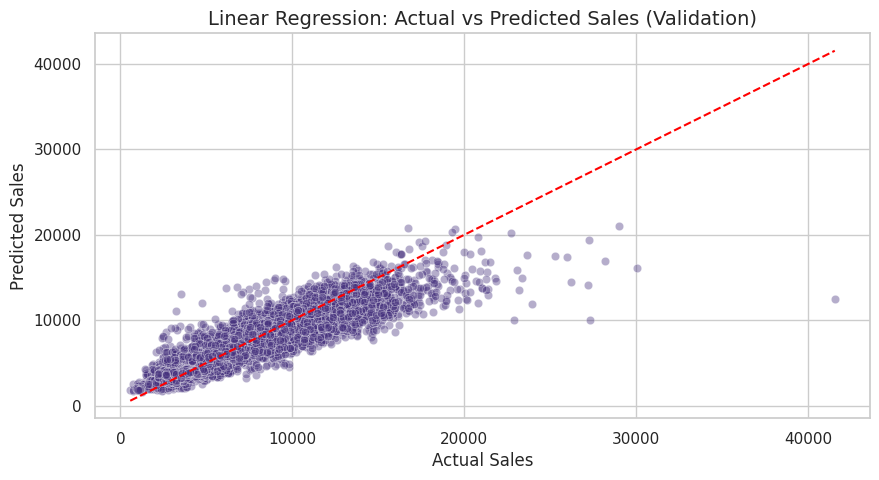

In [31]:
import seaborn as sns, matplotlib.pyplot as plt
sns.scatterplot(x=y_valid, y=pred_lin, alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--')
plt.title("Linear Regression: Actual vs Predicted Sales (Validation)")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")
plt.show()

###Random Forest Regressor

In [33]:
rf = Pipeline([
    ("prep", prep),
    ("model", RandomForestRegressor(
        n_estimators=150,
        max_depth=20,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    ))
])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)
print(f"Random Forest → Valid RMSE: {rmse(y_valid,pred_rf):.2f}, MAPE: {mape(y_valid,pred_rf):.2f}%")

Random Forest → Valid RMSE: 936.93, MAPE: 10.24%


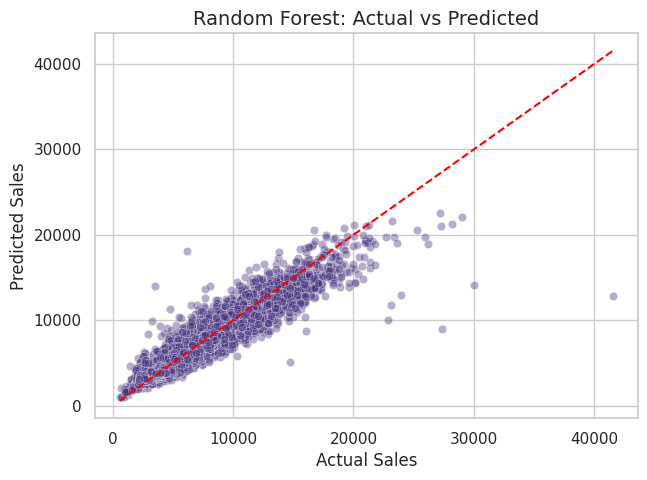

In [34]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_valid, y=pred_rf, alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")
plt.show()

###Merged plot(Linear + Random Forest)

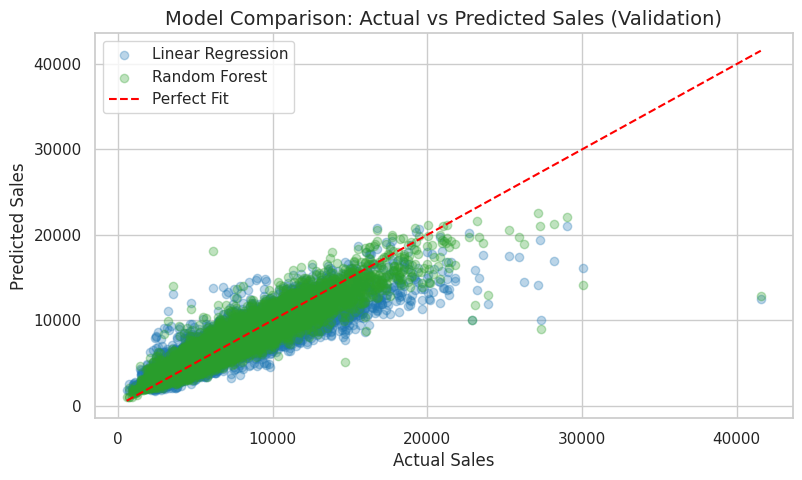

In [35]:
plt.figure(figsize=(9,5))
plt.scatter(y_valid, pred_lin, alpha=0.3, label="Linear Regression", color="#1f77b4")
plt.scatter(y_valid, pred_rf, alpha=0.3, label="Random Forest", color="#2ca02c")
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         "r--", label="Perfect Fit")
plt.title("Model Comparison: Actual vs Predicted Sales (Validation)")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")
plt.legend(); plt.show()

###XGBoost Regressor

In [36]:
try:
    from xgboost import XGBRegressor
    xgb = Pipeline([
        ("prep", prep),
        ("model", XGBRegressor(
            n_estimators=800, max_depth=8,
            learning_rate=0.05, subsample=0.8,
            colsample_bytree=0.8, objective="reg:squarederror",
            random_state=42, n_jobs=-1))
    ])
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_valid)
    print(f"XGBoost → Valid RMSE: {rmse(y_valid,pred_xgb):.2f}, MAPE: {mape(y_valid,pred_xgb):.2f}%")
    XGB_OK=True
except Exception as e:
    print("⚠️ XGBoost not available:", e)
    XGB_OK=False

XGBoost → Valid RMSE: 889.58, MAPE: 9.80%


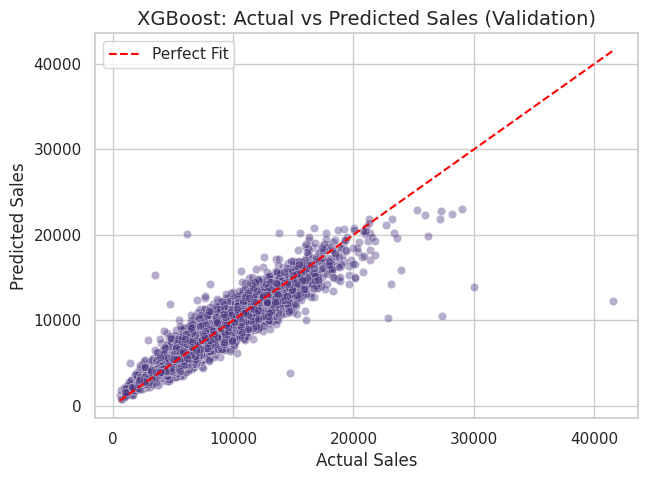

In [37]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_valid, y=pred_xgb, alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--', label="Perfect Fit")

plt.title("XGBoost: Actual vs Predicted Sales (Validation)")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.show()

###3D Visualization on how sales vary by promo and dayofweek

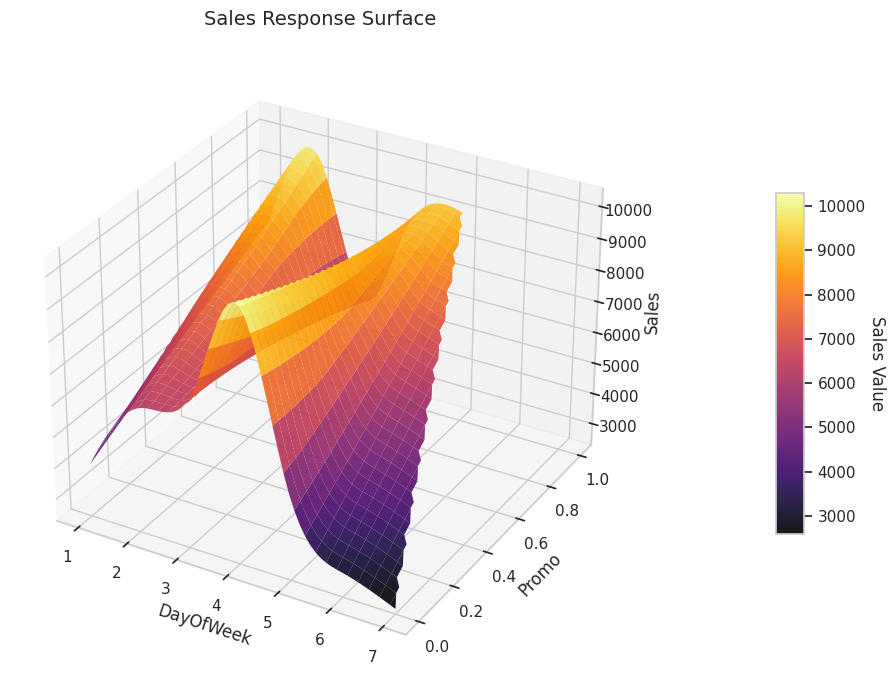

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

sample = valid_df.sample(5000, random_state=42)
x = sample["DayOfWeek"]
y = sample["Promo"]
z = sample["Sales"]

xi = np.linspace(x.min(), x.max(), 60)
yi = np.linspace(y.min(), y.max(), 60)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method="cubic")

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    xi, yi, zi,
    cmap="inferno",
    edgecolor="none",
    alpha=0.9)

cbar = fig.colorbar(surf, shrink=0.55, aspect=12, pad=0.15)
cbar.set_label("Sales Value", rotation=270, labelpad=15)

ax.set_xlabel("DayOfWeek")
ax.set_ylabel("Promo")
ax.set_zlabel("Sales")
ax.set_title("Sales Response Surface", pad=20)
plt.tight_layout()
plt.show()

##Residual Analysis for best model

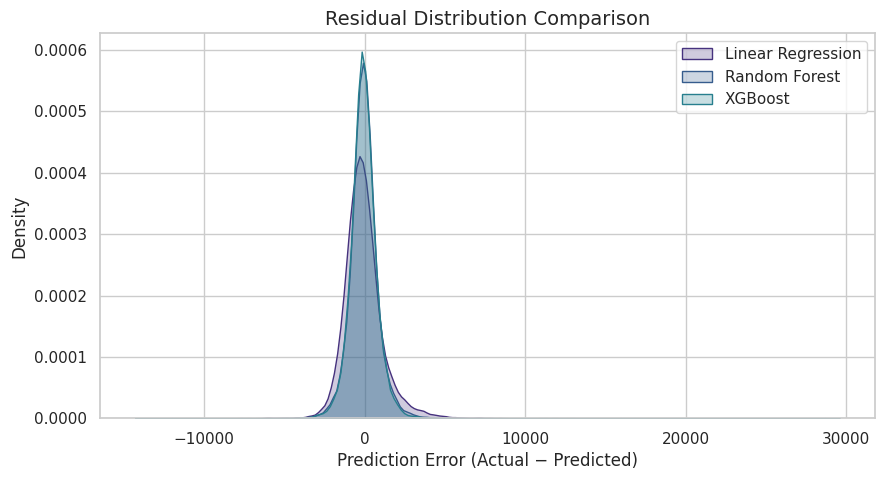

In [45]:
res_lin = y_valid - pred_lin
res_rf  = y_valid - pred_rf
res_xgb = y_valid - pred_xgb

sns.kdeplot(res_lin, label="Linear Regression", shade=True)
sns.kdeplot(res_rf,  label="Random Forest", shade=True)
sns.kdeplot(res_xgb, label="XGBoost", shade=True)

plt.title("Residual Distribution Comparison")
plt.xlabel("Prediction Error (Actual − Predicted)")
plt.legend()
plt.show()

##Feature Importance

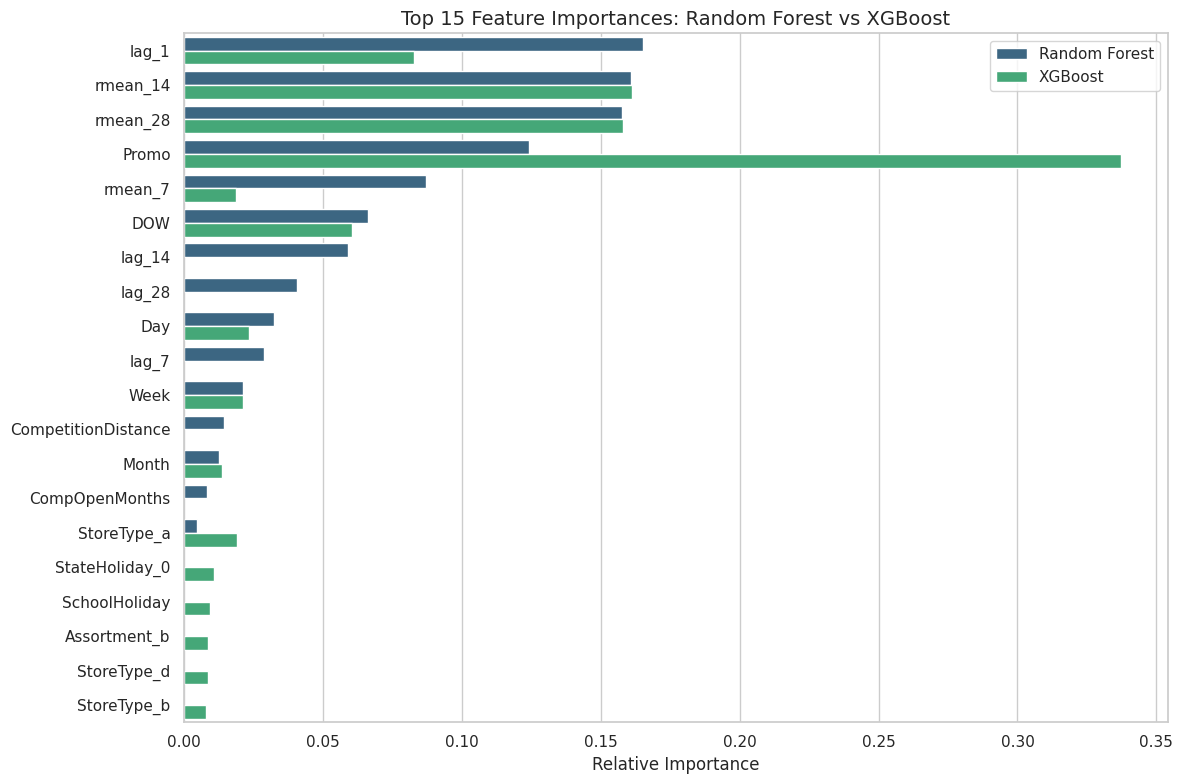

In [49]:
feat_names = list(prep.transformers_[0][1].get_feature_names_out(cat_features)) + num_features

rf_imp = rf.named_steps["model"].feature_importances_

rf_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": rf_imp,
    "Model": "Random Forest"
}).sort_values("Importance", ascending=False).head(15)

xgb_imp = xgb.named_steps["model"].feature_importances_

xgb_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": xgb_imp,
    "Model": "XGBoost"
}).sort_values("Importance", ascending=False).head(15)

imp_all = pd.concat([rf_df, xgb_df])

plt.figure(figsize=(12,8))
sns.barplot(
    data=imp_all,
    y="Feature",
    x="Importance",
    hue="Model",
    palette="viridis")
plt.title("Top 15 Feature Importances: Random Forest vs XGBoost")
plt.xlabel("Relative Importance")
plt.ylabel("")
plt.legend(title="")
plt.tight_layout()
plt.show()


###Combined Performance Table

In [54]:
tv = pd.concat([train_df, valid_df]).sort_values(["Store", "Date"])

base_t1 = tv.groupby("Store")["Sales"].shift(1).loc[valid_df.index]
base_t7 = tv.groupby("Store")["Sales"].shift(7).loc[valid_df.index]

perf = pd.DataFrame({
    "RMSE": [
        rmse(y_valid, base_t1),
        rmse(y_valid, base_t7),
        rmse(y_valid, pred_lin),
        rmse(y_valid, pred_rf),
        rmse(y_valid, pred_xgb),
    ],
    "MAPE (%)": [
        mape(y_valid, base_t1),
        mape(y_valid, base_t7),
        mape(y_valid, pred_lin),
        mape(y_valid, pred_rf),
        mape(y_valid, pred_xgb),
    ]
}, index=[
    "Baseline t−1",
    "Baseline t−7",
    "Linear",
    "Random Forest",
    "XGBoost"
]).round(2)

display(perf.style.background_gradient(cmap="YlGnBu"))

,RMSE,MAPE (%)
Baseline t−1,2067.590000,20.260000
Baseline t−7,3078.850000,37.660000
Linear,1260.060000,14.070000
Random Forest,936.930000,10.240000
XGBoost,889.580000,9.800000


###Overlayed line plot (per-store) comparing all models

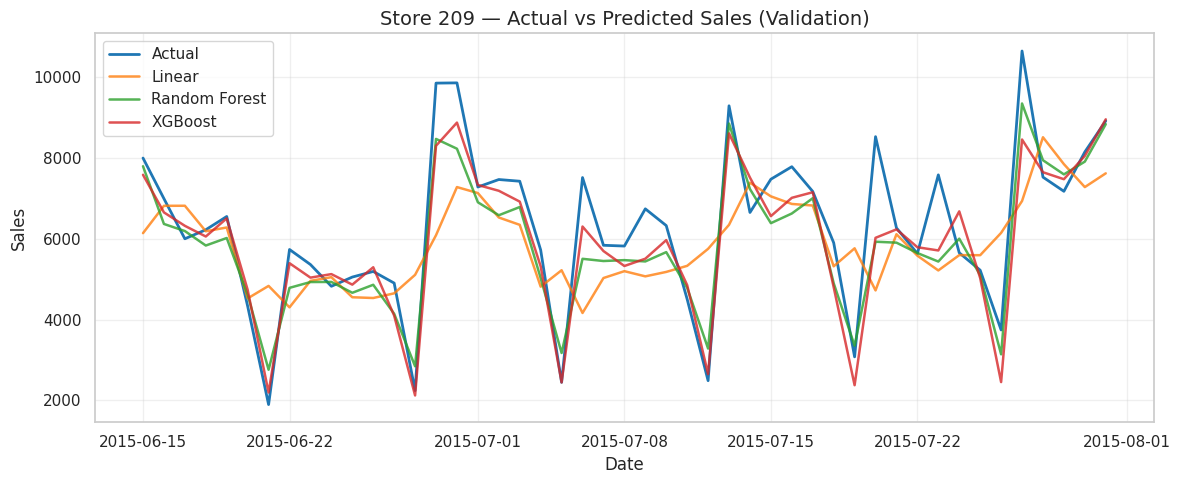

In [55]:
store_id = int(valid_df["Store"].mode().iloc[0])
view = valid_df[valid_df["Store"]==store_id].copy().sort_values("Date")

view["pred_lin"] = linreg.predict(view[feature_cols])
view["pred_rf"]  = rf.predict(view[feature_cols])
view["pred_xgb"] = xgb.predict(view[feature_cols])

plt.figure(figsize=(12,5))
plt.plot(view["Date"], view["Sales"], label="Actual", color="#1f77b4", linewidth=2)
plt.plot(view["Date"], view["pred_lin"], label="Linear", color="#ff7f0e", linewidth=1.8, alpha=0.8)
plt.plot(view["Date"], view["pred_rf"],  label="Random Forest", color="#2ca02c", linewidth=1.8, alpha=0.8)
plt.plot(view["Date"], view["pred_xgb"], label="XGBoost", color="#d62728", linewidth=1.8, alpha=0.8)

plt.title(f"Store {store_id} — Actual vs Predicted Sales (Validation)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()